<a href="https://colab.research.google.com/github/ed-chin-git/DS-Sprint-01-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=314.0622128233107, mobile=False), User(purchased=False, time_on_site=287.25219340867983, mobile=False), User(purchased=False, time_on_site=207.19836929358604, mobile=True), User(purchased=False, time_on_site=332.4846843052783, mobile=False), User(purchased=False, time_on_site=122.75701057170221, mobile=True), User(purchased=True, time_on_site=154.78067405106745, mobile=True), User(purchased=False, time_on_site=91.61128574700513, mobile=True), User(purchased=False, time_on_site=67.44212733032256, mobile=True), User(purchased=False, time_on_site=275.68476455203165, mobile=True), User(purchased=False, time_on_site=202.98283398169204, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,314.062213,False
1,False,287.252193,False
2,False,207.198369,True
3,False,332.484684,False
4,False,122.757011,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.948929440553138,6.043526494225524,6.178988512218049,6.745529945663332,7.127727175765896,7.533843725596782,7.719382930604839,8.192999954278168,8.562820557613712,8.786482572312824,...,580.3286437829317,580.5752473553267,583.1046920590994,584.4484178129385,586.0601394975604,587.7388450783632,588.4890633752539,594.9512240392679,596.1072490622192,598.4784822493544
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,0,1,0,1,...,1,0,1,1,0,1,0,0,0,0
True,0,0,1,0,0,0,1,0,1,0,...,0,1,0,0,1,0,1,1,1,1


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.356, 124.455]","(124.455, 242.961]","(242.961, 361.467]","(361.467, 479.973]","(479.973, 598.478]"
purchased,,,,,
False,261,227,123,36,26
True,98,107,71,23,28


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.356, 124.455]","(124.455, 242.961]","(242.961, 361.467]","(361.467, 479.973]","(479.973, 598.478]"
purchased,,,,,
False,0.727019,0.679641,0.634021,0.610169,0.481481
True,0.272981,0.320359,0.365979,0.389831,0.518519


In [9]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.624,0.689333
True,0.376,0.310667


In [10]:
# More on binning
pd.cut(user_data['time_on_site'], 5)

0      (242.961, 361.467]
1      (242.961, 361.467]
2      (124.455, 242.961]
3      (242.961, 361.467]
4        (5.356, 124.455]
5      (124.455, 242.961]
6        (5.356, 124.455]
7        (5.356, 124.455]
8      (242.961, 361.467]
9      (124.455, 242.961]
10     (242.961, 361.467]
11     (124.455, 242.961]
12       (5.356, 124.455]
13       (5.356, 124.455]
14       (5.356, 124.455]
15     (124.455, 242.961]
16       (5.356, 124.455]
17     (124.455, 242.961]
18       (5.356, 124.455]
19     (124.455, 242.961]
20       (5.356, 124.455]
21       (5.356, 124.455]
22     (361.467, 479.973]
23     (124.455, 242.961]
24     (361.467, 479.973]
25     (124.455, 242.961]
26     (242.961, 361.467]
27     (242.961, 361.467]
28     (124.455, 242.961]
29     (124.455, 242.961]
              ...        
970    (124.455, 242.961]
971      (5.356, 124.455]
972    (242.961, 361.467]
973      (5.356, 124.455]
974    (361.467, 479.973]
975    (124.455, 242.961]
976    (242.961, 361.467]
977      (5.

In [11]:
help(pd.cut)

Help on function cut in module pandas.core.reshape.tile:

cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)
    Return indices of half-open bins to which each value of `x` belongs.
    
    Parameters
    ----------
    x : array-like
        Input array to be binned. It has to be 1-dimensional.
    bins : int, sequence of scalars, or IntervalIndex
        If `bins` is an int, it defines the number of equal-width bins in the
        range of `x`. However, in this case, the range of `x` is extended
        by .1% on each side to include the min or max values of `x`. If
        `bins` is a sequence it defines the bin edges allowing for
        non-uniform bin width. No extension of the range of `x` is done in
        this case.
    right : bool, optional
        Indicates whether the bins include the rightmost edge or not. If
        right == True (the default), then the bins [1,2,3,4] indicate
        (1,2], (2,3], (3,4].
    labels : array or boole

In [12]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
            normalize='columns')

mobile                        False     True 
purchased time_on_site                       
False     (5.356, 124.455]    0.128  0.305333
          (124.455, 242.961]  0.132  0.258667
          (242.961, 361.467]  0.116  0.125333
          (361.467, 479.973]  0.144  0.000000
          (479.973, 598.478]  0.104  0.000000
True      (5.356, 124.455]    0.032  0.120000
          (124.455, 242.961]  0.068  0.120000
          (242.961, 361.467]  0.072  0.070667
          (361.467, 479.973]  0.092  0.000000
          (479.973, 598.478]  0.112  0.000000

In [13]:
help(user_data.plot.bar)

Help on method bar in module pandas.plotting._core:

bar(x=None, y=None, **kwds) method of pandas.plotting._core.FramePlotMethods instance
    Vertical bar plot
    
    .. versionadded:: 0.17.0
    
    Parameters
    ----------
    x, y : label or position, optional
        Coordinates for each point.
    **kwds : optional
        Keyword arguments to pass on to :py:meth:`pandas.DataFrame.plot`.
    
    Returns
    -------
    axes : matplotlib.AxesSubplot or np.array of them



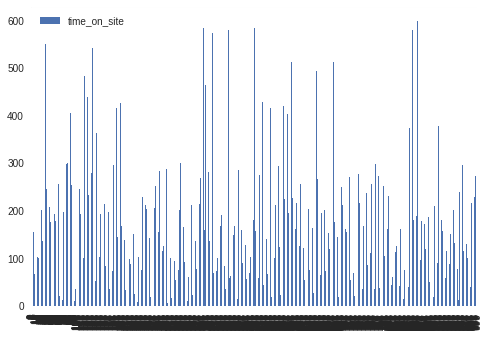

In [14]:
user_data.plot.bar()

In [15]:
# So we have a working barchart method
# Does it just expand our crosstab?
ct = pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
                 normalize='columns')
ct

mobile                        False     True 
purchased time_on_site                       
False     (5.356, 124.455]    0.128  0.305333
          (124.455, 242.961]  0.132  0.258667
          (242.961, 361.467]  0.116  0.125333
          (361.467, 479.973]  0.144  0.000000
          (479.973, 598.478]  0.104  0.000000
True      (5.356, 124.455]    0.032  0.120000
          (124.455, 242.961]  0.068  0.120000
          (242.961, 361.467]  0.072  0.070667
          (361.467, 479.973]  0.092  0.000000
          (479.973, 598.478]  0.112  0.000000

In [16]:
dir(ct)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',


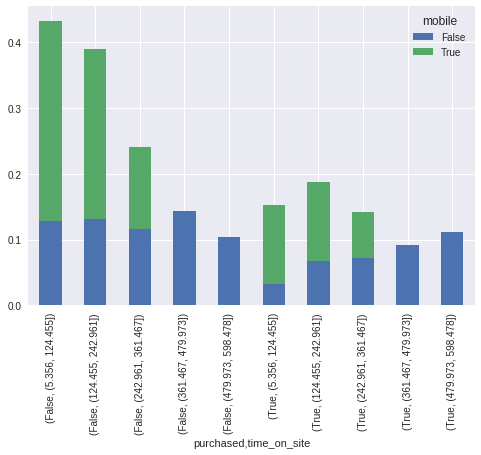

In [17]:
ct.plot(kind='bar', stacked=True)

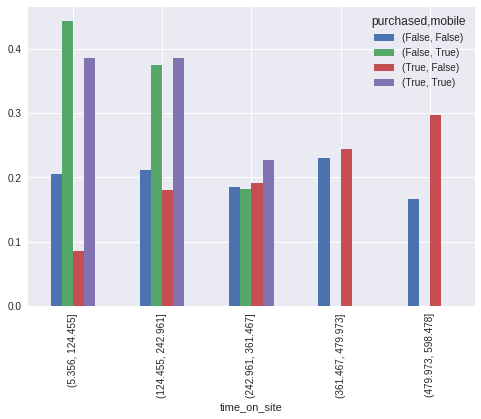

In [18]:
# Courtesy of A
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            normalize='columns').plot(kind = 'bar', stacked = False);

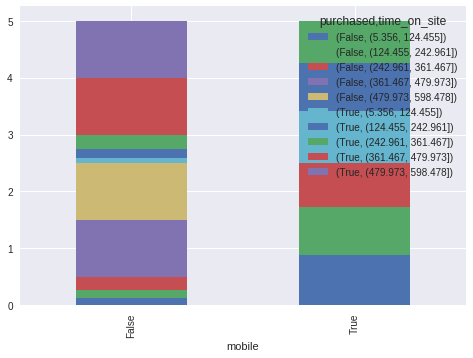

In [19]:
# Starting point for mobile/desktop stacked barcharts
# Probably want to redo with fewer time-bins
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            normalize='columns').plot(kind = 'bar', stacked = True);

In [20]:
'scatter' in dir(ct.plot)

True

In [0]:
grouped_data = user_data['mobile'].groupby(user_data['purchased'])

In [22]:
dir(grouped_data)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_doc',
 '_aggregate',
 '_aggregate_multiple_funcs',
 '_aggregate_named',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_builtin_table',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cython_agg_general',
 '_cython_table',
 '_cython_transform',
 '_def_str',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_get_index',
 '_get_indices',
 '_gotitem',
 '_group_selection',
 '_index_with_as_index',
 '_internal_names',
 '_internal_

In [0]:
# TODO continue exploring grouped_data, grouped_data.plot, etc.

In [24]:
[x for x in dir(ct) if 'add' in x]  # Courtesy of Ryan Herr

['__add__',
 '__iadd__',
 '__radd__',
 '_add_numeric_operations',
 '_add_series_only_operations',
 '_add_series_or_dataframe_operations',
 '_dir_additions',
 'add',
 'add_prefix',
 'add_suffix',
 'radd']

In [25]:
ct_props = dir(ct)
'add' in ct_props

True

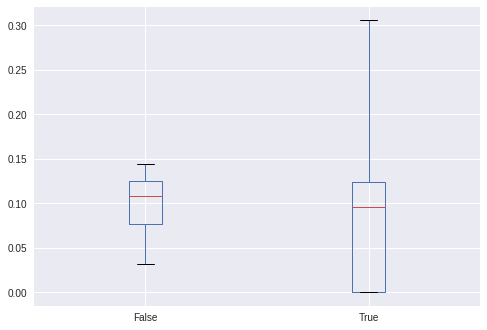

In [26]:
ct.boxplot()

In [27]:
!apt install r-base

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  autoconf automake autopoint autotools-dev bsdmainutils bzip2-doc cdbs
  debhelper dh-autoreconf dh-strip-nondeterminism dh-translations file
  fontconfig gettext gettext-base groff-base intltool intltool-debian jq
  libarchive-cpio-perl libarchive-zip-perl libauthen-sasl-perl libbz2-dev
  libcairo2 libcroco3 libdata-dump-perl libdatrie1 libdrm-amdgpu1
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libencode-locale-perl
  libfile-basedir-perl libfile-desktopentry-perl libfile-listing-perl
  libfile-mimeinfo-perl libfile-stripnondeterminism-perl libfile-which-perl
  libfont-afm-perl libfontenc1 libgl1 libgl1-mesa-dri libgl1-mesa-glx
  libglx-mesa0 libglx0 libhtml-form-perl libhtml-format-perl
  libhtml-parser-perl libhtml-tagset-perl libhtml-tree-perl
  libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libht

In [28]:
!R --version

R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



In [29]:
!pip install rpy2

    100% |████████████████████████████████| 204kB 5.0MB/s 
  Running setup.py bdist_wheel for rpy2 ... - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/10/e7/1b/e1d57fc4ad3d6d650ea93b5ed053cd1d7d37ac0be85d864b0c
Successfully built rpy2


In [30]:
# Download the data
data_url = 'https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda'

!wget $data_url
!ls

--2018-11-09 14:45:10--  https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lockedata/datasauRus/master/data/simpsons_paradox.rda [following]
--2018-11-09 14:45:10--  https://raw.githubusercontent.com/lockedata/datasauRus/master/data/simpsons_paradox.rda
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7090 (6.9K) [application/octet-stream]
Saving to: ‘simpsons_paradox.rda’

simpsons_paradox.rd 100%[===================>]   6.92K  --.-KB/s    in 0s      

2018-11-09 14:45:10 (59.0 MB/s) - ‘simpsons_paradox.rda

In [31]:
!pip install tzlocal

  Running setup.py bdist_wheel for tzlocal ... - \ done
  Stored in directory: /root/.cache/pip/wheels/15/ae/df/a67bf1ed84e9bf230187d36d8dcfd30072bea0236cb059ed91
Successfully built tzlocal


In [32]:
# Trying to load R data in Python
# https://itsalocke.com/datasaurus/reference/simpsons_paradox
# https://stackoverflow.com/questions/40160149/reading-rda-file-in-python-as-a-pandas-data-frame#40161783

import rpy2.robjects as robjects
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

# load your file
robjects.r['load']('simpsons_paradox.rda')

# use the default conversion rules to which the pandas conversion
# is added
with localconverter(default_converter + pandas2ri.converter) as cv:
    df = robjects.r["data"]

matrix = robjects.r['data']

matrix

KeyboardInterrupt: ignored

In [0]:
thing = df()

In [0]:
for item in thing.items():
  print(item)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [33]:
import pandas as pd

# Load PERSONS.CSV from
# https://raw.githubusercontent.com/ed-chin-git/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv

data_url='https://raw.githubusercontent.com/ed-chin-git/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
df=pd.read_csv(data_url, index_col=0)


# Let's have a look
print('#Rows =',df.shape[0],'\n#Columns =',df.shape[1])
print('\n== data Types ==\n',df.dtypes,'\n')
df.head()

#Rows = 1200 
#Columns = 3

== data Types ==
 age              int64
weight           int64
exercise_time    int64
dtype: object 



,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [34]:
# Find NaN's 

print('\n== Nan list ==\n', df.isna().sum() )


== Nan list ==
 age              0
weight           0
exercise_time    0
dtype: int64


In [35]:
#  looks pretty clean, now get some stats
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [36]:
# Massage the data a bit...

# create 5 equal-sized bins of each column 
#  they are all continuous data.....
time_bins = pd.cut(df['exercise_time'], 5  )  
age_bins = pd.cut(df['age'], 3,precision=0)  
weight_bins = pd.cut(df['weight'], 3,precision=0)

# cross tabulate the bins  Show percentages  
pd.crosstab([age_bins,weight_bins],time_bins, normalize='columns')

exercise_time                (-0.3, 60.0]  (60.0, 120.0]  (120.0, 180.0]  \
age          weight                                                        
(18.0, 39.0] (100.0, 149.0]      0.100719       0.101266        0.215247   
             (149.0, 197.0]      0.107914       0.107595        0.147982   
             (197.0, 246.0]      0.115108       0.047468        0.017937   
(39.0, 59.0] (100.0, 149.0]      0.068345       0.072785        0.147982   
             (149.0, 197.0]      0.089928       0.117089        0.121076   
             (197.0, 246.0]      0.075540       0.069620        0.026906   
(59.0, 80.0] (100.0, 149.0]      0.136691       0.164557        0.152466   
             (149.0, 197.0]      0.143885       0.221519        0.147982   
             (197.0, 246.0]      0.161871       0.098101        0.022422   

exercise_time                (180.0, 240.0]  (240.0, 300.0]  
age          weight                                          
(18.0, 39.0] (100.0, 149.0]        0.302083        0.345550  
             (149.0, 197.0]        0.177083        0.062827  
             (197.0, 246.0]        0.000000        0.000000  
(39.0, 59.0] (100.0, 149.0]        0.234375        0.486911  
             (149.0, 197.0]        0.104167        0.068063  
             (197.0, 246.0]        0.000000        0.000000  
(59.0, 80.0] (100.0, 149.0]        0.125000        0.026178  
             (149.0, 197.0]        0.057292        0.010471  
             (197.0, 246.0]        0.000000        0.000000

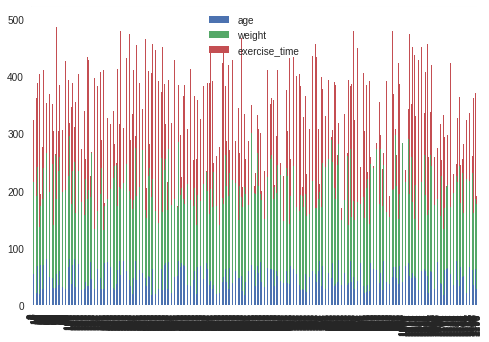

In [120]:
#  Try a Stacked Bar Chart

df.plot(kind='bar', stacked=True);

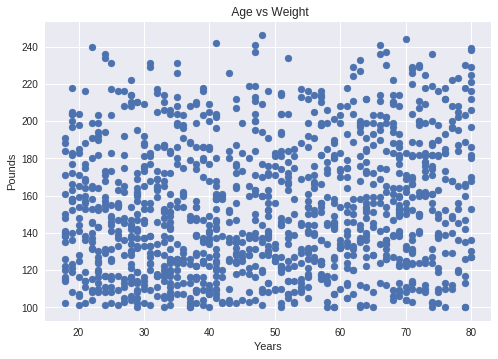

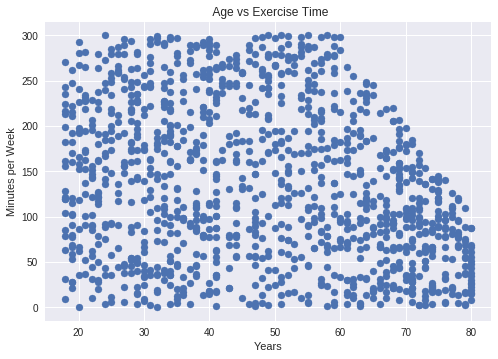

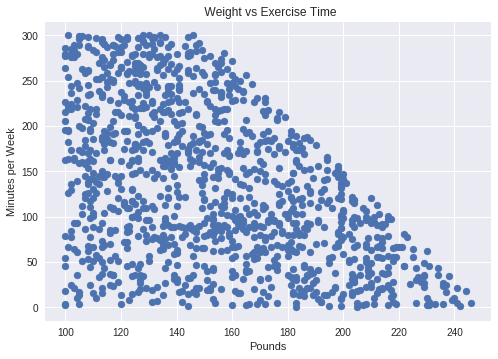

In [121]:
# Scatter_plot Variations

import matplotlib.pyplot as plt
plt.scatter(df.age,df.weight, marker = 'o')
plt.title(' Age vs Weight')
plt.xlabel('Years')
plt.ylabel('Pounds')
plt.show()

plt.scatter(df.age, df.exercise_time, marker = 'o')
plt.title(' Age vs Exercise Time')
plt.xlabel('Years')
plt.ylabel('Minutes per Week')
plt.show()

plt.scatter(df.weight, df.exercise_time, marker = 'o')
plt.title(' Weight vs Exercise Time')
plt.xlabel('Pounds')
plt.ylabel('Minutes per Week')
plt.show()


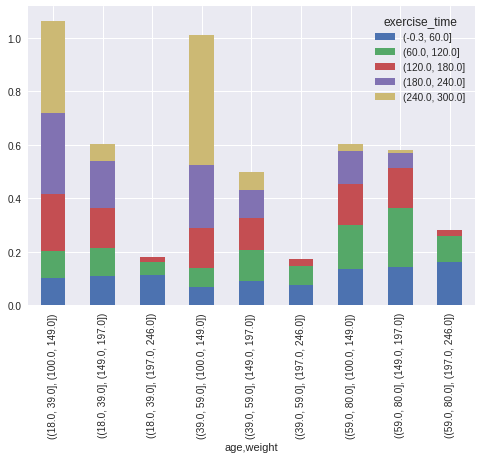

In [37]:
# Plot the Cross Tabulation

x_tab = pd.crosstab([age_bins,weight_bins],time_bins, normalize='columns')
x_tab.plot(kind='bar', stacked=True);


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?


        The data contains a persons age, weight,  and amount of time they exercise. 


2.  What are the relationships between the variables?
                        Age vs Weight
                        Age vs Exercise Time
                        Weight vs Exercise Time

3.  Which relationships are "real", and which spurious?
                   
                   Age vs Weight  seems to be spurious
                   Age vs Exercise time seems to be somewhat 'real'
                   Weight vs Exercise time seems to be 'real'





## EXTRA WORK :  Crosstab  experimentation 

In [0]:
import pandas as pd
import seaborn as sns
# Define the headers since the data does not have any
headers = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration",
           "num_doors", "body_style", "drive_wheels", "engine_location",
           "wheel_base", "length", "width", "height", "curb_weight",
           "engine_type", "num_cylinders", "engine_size", "fuel_system",
           "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
           "city_mpg", "highway_mpg", "price"]

# Read in the CSV file and convert "?" to NaN
df_raw = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/autos/imports-85.data",
                     header=None, names=headers, na_values="?" )

# Define a list of models that we want to review
models = ["toyota","nissan","mazda", "honda", "mitsubishi", "subaru", "volkswagen", "volvo"]

# Create a copy of the data with only the top 8 manufacturers
df = df_raw[df_raw.make.isin(models)].copy()

In [42]:
pd.crosstab(df.make, df.body_style)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0,0,7,5,1
mazda,0,0,10,7,0
mitsubishi,0,0,9,4,0
nissan,0,1,5,9,3
subaru,0,0,3,5,4
toyota,1,3,14,10,4
volkswagen,1,0,1,9,1
volvo,0,0,0,8,3


In [43]:
df.groupby(['make', 'body_style'])['body_style'].count().unstack().fillna(0)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0.0,0.0,7.0,5.0,1.0
mazda,0.0,0.0,10.0,7.0,0.0
mitsubishi,0.0,0.0,9.0,4.0,0.0
nissan,0.0,1.0,5.0,9.0,3.0
subaru,0.0,0.0,3.0,5.0,4.0
toyota,1.0,3.0,14.0,10.0,4.0
volkswagen,1.0,0.0,1.0,9.0,1.0
volvo,0.0,0.0,0.0,8.0,3.0


In [44]:
df.pivot_table(index='make', columns='body_style', aggfunc={'body_style':len}, fill_value=0)

body_style                              
body_style convertible hardtop hatchback sedan wagon
make                                                
honda                0       0         7     5     1
mazda                0       0        10     7     0
mitsubishi           0       0         9     4     0
nissan               0       1         5     9     3
subaru               0       0         3     5     4
toyota               1       3        14    10     4
volkswagen           1       0         1     9     1
volvo                0       0         0     8     3

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.


- [Common Probability Distributions](https://blog.cloudera.com/blog/2015/12/common-probability-distributions-the-data-scientists-crib-sheet/)
- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)